In [1]:
import sys
import os
absFilePath = os.path.abspath('example_state_switching.py')
fileDir = os.path.dirname(absFilePath)
parentDir = os.path.dirname(fileDir)

import func_pytorch as functions
from opt_pytorch import FR_algorithm

import torch
import pickle
import matplotlib.pyplot as plt
from pylab import figure, cm
import random

goal='sync'
bifurcation='high'
noise_strength= 0.0 
realizations=1
noise=0
parameters = functions.set_parameters(goal,bifurcation,parentDir)

# 10 nodes
n_nodes = 10
A = parameters['A'][:n_nodes,:n_nodes]
#A = np.zeros((5,5))
parameters['A'] = A
parameters['N'] = n_nodes


#Set dimensions
T= 30 #simulation and control time 
dt=0.1 #time stepsize
tsteps=int(T/dt) #number of timesteps
d=2 #dimension of each FitzHugh-Nagumo node

#set paraeters of the cost functional
I_p_in= 0.0005 #penalize precision
I_e= 1.0 #penalize control energy should be >0
I_s= 0.0#enforce sparsity

switchfromto='none'
I_p=I_p_in

#choose initial condition for control
control=-torch.ones((tsteps,parameters['N']))*0.002
control=control.reshape(tsteps*parameters['N'])

def set_random_initial_conds_for_nodes(bifurcation,noise_strength,tsteps,d,dt,parameters,realizations,noise):

    #unpack parameters
    alpha=parameters['alpha']
    beta=parameters['beta']
    gamma=parameters['gamma']
    delta=parameters['delta']
    epsilon=parameters['epsilon']
    tau=parameters['tau']
    sigma=parameters['sigma']
    mu=parameters['mu']
    A=parameters['A']
    N=parameters['N']

    #set random initials on circle with set amplitudes
    if bifurcation=='low':
        ini_y=torch.rand(N)/2+0.1
        ini_z=torch.rand(N)/5+.5
    elif bifurcation=='high':
        ini_y=torch.rand(N)
        ini_z=torch.rand(N)*0.3+1.0
    
    ini_transient=torch.stack((ini_y, ini_z)).transpose(0, 1)
    ini_transient=ini_transient.reshape(2,N)
    #print(ini_transient)

    return ini_transient

node_ic=functions.set_random_initial_conds_for_nodes(bifurcation,noise_strength,tsteps,d,dt,parameters,realizations,noise)
#ic_state_high=functions.set_random_initial_conds_for_nodes('high',noise_strength,tsteps,d,dt,parameters_high,realizations,noise)
target_output=torch.ones((parameters['N'],parameters['N']))

args = {
    'tsteps':tsteps,
    'dt':dt,
    'd':d,
    'I_p':I_p,
    'I_e':I_e,
    'I_s':I_s,
    'target_output':target_output,
    'node_ic':node_ic,
    'realizations':realizations,
    'noise':noise
    }
args.update(parameters)

In [2]:
import torch
from torch import nn
import torch.nn.functional as F

from torch.nn import Sequential, Linear, ReLU
from torch_geometric.utils import scatter
from torch_geometric.nn import MetaLayer

In [3]:
def data_nocontrol(batch_size, sim_length,**args):
    args['tsteps'] = sim_length
    N = args['N']
    dt = args['dt']
    args['T'] = int(sim_length*dt)
    # note that time steps = T/dt, dt=0.1
    while True:
        data = torch.zeros((batch_size, sim_length, 2, N))
        nocontrol = torch.zeros((sim_length, N))

        for b in range(batch_size):
            init = functions.set_random_initial_conds_for_nodes(bifurcation,noise_strength,sim_length,d,dt,parameters,realizations,noise)# (2,N)
            args['node_ic'] = init
            data[b, :, :, :] = functions.plot_runge_kutta(functions.ODE_FHN_network,nocontrol, **args) # gives time seris of legth sim_length

        # To return all the data at once
        # yield(data)

        # To return the data in chunks of length L
        L = 10
        num_chunks = sim_length // L
        for i in range(sim_length-L+1):
            yield(data[:, i : i+L, :, :])

In [19]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        input_size = 2
        output_size = 2
        self.fc1 = nn.Linear(input_size, 8)   
        self.fc2 = nn.Linear(8, 16) 
        self.fc3 = nn.Linear(16, 8) 
        self.fc4 = nn.Linear(8, output_size)  


    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [20]:
model = SimpleMLP()
generator = data_nocontrol(1, 400,**args)
states = next(generator)
states = states.squeeze(0)
next_state = model(states[0,:,:].T)

In [24]:
next_state.shape

torch.Size([10, 2])

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleMLP()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
loss_fn = nn.MSELoss()
look_ahead = 10
train_losses = []

generator = data_nocontrol(1,400,**args)
loss_value = float('inf')
max_epochs = 100000
epoch = 0
# Training loop
while loss_value > 1e-6 and epoch < max_epochs:
    # Fetch the next batch of data
    states = next(generator) #[batch_size,look_ahead,2,N]
    states = states.to(device)
    if states.shape[0] == 1:
        states = states.squeeze(0)
    
    model.train()
    optimizer.zero_grad()
    loss = 0
    current_state = states[0, :]
    for k in range(look_ahead-1):
        prediction = model(current_state.T).T
        #print(prediction.shape,states[k + 1, :].shape)
        loss = loss + loss_fn(prediction, states[k + 1, :])
        current_state = prediction
    loss.backward()
    optimizer.step()
    
    # Store and print the loss
    loss_value = loss.item()
    train_losses.append(loss_value)
    epoch +=1
    if (epoch + 1) % 10000 == 0: 
        print(f"Epoch {epoch + 1},Current Loss: {loss_value}")


Epoch 10000,Current Loss: 0.0008915922371670604
Epoch 20000,Current Loss: 6.872771336929873e-05
Epoch 30000,Current Loss: 7.0566515205428e-05
Epoch 40000,Current Loss: 1.8108999938704073e-05
Epoch 50000,Current Loss: 0.00011419171642046422
Epoch 60000,Current Loss: 1.194899687106954e-05
Epoch 70000,Current Loss: 7.988577999640256e-05
Epoch 80000,Current Loss: 1.0822936019394547e-05
Epoch 90000,Current Loss: 2.9127317247912288e-05
Epoch 100000,Current Loss: 0.0010492111323401332


In [28]:
generator = data_nocontrol(1,1000,**args)
model.eval()
sim_length=400
t = 0
states= next(generator)
states= states.to(device)
if states.shape[0] == 1:
    states = states.squeeze(0)
state = states[0,:,:]
pred_list = [state]
true_list = [state]

while t<sim_length:
    x = pred_list[t]
    pred = model(x.T).T
    pred_list.append(pred)
    
    states= next(generator) 
    states= states.to(device)
    if states.shape[0] == 1:
        states = states.squeeze(0)
    state = states[0,:,:]
    true_list.append(state)
    t = t+1

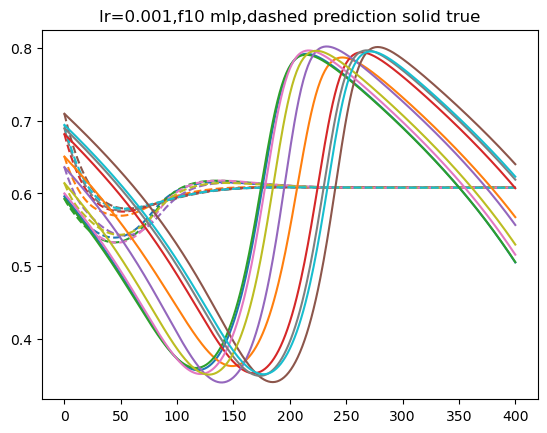

In [30]:
pred_traj = torch.stack(pred_list, dim=0)
true_traj = torch.stack(true_list, dim=0)
plt.plot(pred_traj[:500,0,:].detach(),'--',label='prediction')
plt.plot(true_traj[:500,0,:],label='true')
plt.title('lr=0.001,f10 mlp,dashed prediction solid true')
plt.show()

In [4]:
class SimpleMLP(nn.Module):
    def __init__(self, hidden_sizes):
        super(SimpleMLP, self).__init__()
        
        input_size = 2
        output_size = 2
        
        layers = []
        current_input = input_size
        
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(current_input, hidden_size))
            layers.append(nn.ReLU())
            current_input = hidden_size

        layers.append(nn.Linear(current_input, output_size))
        
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)

In [ ]:
import os
import pandas as pd

# Ensure that the 'grid_search' directory exists
save_path = 'mlp_grid_search'
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Define your grid
node_hidden_layer_combinations = [[6,3],[6,12,6], [6,12,24,12,6], [16,32,16], [16, 32, 64,32,16]]
learning_rates = [0.001, 0.01, 0.1]

grid = [(n_sizes, lr) for n_sizes in node_hidden_layer_combinations for lr in learning_rates]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer_class = torch.optim.Adam
loss_fn = nn.MSELoss()
look_ahead = 10

max_epochs = 100000

train_generator = data_nocontrol(1, 400, **args)  
valid_generator = data_nocontrol(1, 400, **args)  # A separate generator for validation

# Start the grid search
results = []
for node_sizes, learning_rate in grid:
    print(f"Training for Node Hidden Sizes: {node_sizes} and Learning Rate: {learning_rate}")

    # Create your models with the current hyperparameters

    model = SimpleMLP(node_sizes).to(device)

    optimizer = optimizer_class(model.parameters(), lr=learning_rate, weight_decay=5e-4)
    
    train_losses = []
    valid_losses = []
    epoch = 0
    loss_value = float('inf')
    
    # Your training loop remains largely unchanged
    while loss_value > 1e-6 and epoch < max_epochs:
        # Training step
        states = next(train_generator)
        states = states.to(device)
        if states.shape[0] == 1:
            states = states.squeeze(0)
        
        model.train()
        optimizer.zero_grad()
        loss = 0
        current_state = states[0, :]
        for k in range(look_ahead-1):
            prediction = model(current_state.T).T
            loss = loss + loss_fn(prediction, states[k + 1, :])
            current_state = prediction
        
        loss.backward()
        optimizer.step()
        
        # Store and print the loss
        loss_value = loss.item()
        train_losses.append(loss_value)
        
        # Validation step
        with torch.no_grad():
            model.eval()  # Switch the model to evaluation mode
            states = next(valid_generator)
            states = states.to(device)
            if states.shape[0] == 1:
                states = states.squeeze(0)
            
            valid_loss = 0
            current_state = states[0, :]
            for k in range(look_ahead-1):
                prediction = model(current_state.T).T
                valid_loss += loss_fn(prediction, states[k + 1, :])
                current_state = prediction
                
            valid_losses.append(valid_loss.item())

        epoch += 1
            
    best_train_loss = min(train_losses)
    avg_last_N_train_losses = sum(train_losses[-10000:]) / 10000
    best_valid_loss = min(valid_losses)
    avg_last_N_valid_losses = sum(valid_losses[-10000:]) / 10000
    results.append((node_sizes, learning_rate, best_train_loss, avg_last_N_train_losses, best_valid_loss, avg_last_N_valid_losses,train_losses,valid_losses))
    print(f"epoch {epoch},node sizes{node_sizes},learning rate{learning_rate},best train/val loss{best_train_loss}/{best_valid_loss},avg loss{avg_last_N_train_losses}/{avg_last_N_valid_losses}")
    
    # Save model, training losses, and validation losses if needed
    model_path = os.path.join(save_path, f"model_node_{'_'.join(map(str, node_sizes))}_lr_{learning_rate}.pth")
    train_losses_path = os.path.join(save_path, f"train_losses_node_{'_'.join(map(str, node_sizes))}_lr_{learning_rate}.txt")
    valid_losses_path = os.path.join(save_path, f"valid_losses_node_{'_'.join(map(str, node_sizes))}_lr_{learning_rate}.txt")
    
    torch.save(model.state_dict(), model_path)
    


    df = pd.DataFrame({
        "train_loss": train_losses,
        "valid_loss": valid_losses
    })
    file_name = os.path.join(save_path, f"losses_node_{'_'.join(map(str, node_sizes))}_lr_{learning_rate}.csv")
    df.to_csv(file_name, index=False)        

Training for Node Hidden Sizes: [6, 3] and Learning Rate: 0.001
epoch 69790,node sizes[6, 3],learning rate0.001,best train/val loss8.841312251206546e-07/3.905582161678467e-06,avg loss0.0001874186384186089/0.0007961801327866851
Training for Node Hidden Sizes: [6, 3] and Learning Rate: 0.01
epoch 100000,node sizes[6, 3],learning rate0.01,best train/val loss1.2514970876509324e-05/1.4794885828450788e-05,avg loss0.04922744328097906/0.11685587258259766
Training for Node Hidden Sizes: [6, 3] and Learning Rate: 0.1
epoch 100000,node sizes[6, 3],learning rate0.1,best train/val loss0.0005110736819915473/0.0010881245834752917,avg loss0.05253539923182689/0.11350525484727696
Training for Node Hidden Sizes: [6, 12, 6] and Learning Rate: 0.001
epoch 100000,node sizes[6, 12, 6],learning rate0.001,best train/val loss1.1320356861688197e-05/2.5071509298868477e-05,avg loss0.0032922573840607583/0.00620028190701014
Training for Node Hidden Sizes: [6, 12, 6] and Learning Rate: 0.01
epoch 100000,node sizes[6,

In [5]:
import os
import pandas as pd

# Ensure that the 'grid_search' directory exists
save_path = 'mlp_grid_search'
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Define your grid
node_hidden_layer_combinations = [[16,32,16], [16, 32, 64,32,16]]
learning_rates = [0.001, 0.01, 0.1]

grid = [(n_sizes, lr) for n_sizes in node_hidden_layer_combinations for lr in learning_rates]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer_class = torch.optim.Adam
loss_fn = nn.MSELoss()
look_ahead = 10

max_epochs = 100000

train_generator = data_nocontrol(1, 400, **args)  
valid_generator = data_nocontrol(1, 400, **args)  # A separate generator for validation

# Start the grid search
results = []
for node_sizes, learning_rate in grid:
    print(f"Training for Node Hidden Sizes: {node_sizes} and Learning Rate: {learning_rate}")

    # Create your models with the current hyperparameters

    model = SimpleMLP(node_sizes).to(device)

    optimizer = optimizer_class(model.parameters(), lr=learning_rate, weight_decay=5e-4)
    
    train_losses = []
    valid_losses = []
    epoch = 0
    loss_value = float('inf')
    
    # Your training loop remains largely unchanged
    while loss_value > 1e-6 and epoch < max_epochs:
        # Training step
        states = next(train_generator)
        states = states.to(device)
        if states.shape[0] == 1:
            states = states.squeeze(0)
        
        model.train()
        optimizer.zero_grad()
        loss = 0
        current_state = states[0, :]
        for k in range(look_ahead-1):
            prediction = model(current_state.T).T
            loss = loss + loss_fn(prediction, states[k + 1, :])
            current_state = prediction
        
        loss.backward()
        optimizer.step()
        
        # Store and print the loss
        loss_value = loss.item()
        train_losses.append(loss_value)
        
        # Validation step
        with torch.no_grad():
            model.eval()  # Switch the model to evaluation mode
            states = next(valid_generator)
            states = states.to(device)
            if states.shape[0] == 1:
                states = states.squeeze(0)
            
            valid_loss = 0
            current_state = states[0, :]
            for k in range(look_ahead-1):
                prediction = model(current_state.T).T
                valid_loss += loss_fn(prediction, states[k + 1, :])
                current_state = prediction
                
            valid_losses.append(valid_loss.item())

        epoch += 1
            
    best_train_loss = min(train_losses)
    avg_last_N_train_losses = sum(train_losses[-10000:]) / 10000
    best_valid_loss = min(valid_losses)
    avg_last_N_valid_losses = sum(valid_losses[-10000:]) / 10000
    results.append((node_sizes, learning_rate, best_train_loss, avg_last_N_train_losses, best_valid_loss, avg_last_N_valid_losses,train_losses,valid_losses))
    print(f"epoch {epoch},node sizes{node_sizes},learning rate{learning_rate},best train/val loss{best_train_loss}/{best_valid_loss},avg loss{avg_last_N_train_losses}/{avg_last_N_valid_losses}")
    
    # Save model, training losses, and validation losses if needed
    model_path = os.path.join(save_path, f"model_node_{'_'.join(map(str, node_sizes))}_lr_{learning_rate}.pth")
    train_losses_path = os.path.join(save_path, f"train_losses_node_{'_'.join(map(str, node_sizes))}_lr_{learning_rate}.txt")
    valid_losses_path = os.path.join(save_path, f"valid_losses_node_{'_'.join(map(str, node_sizes))}_lr_{learning_rate}.txt")
    
    torch.save(model.state_dict(), model_path)
    


    df = pd.DataFrame({
        "train_loss": train_losses,
        "valid_loss": valid_losses
    })
    file_name = os.path.join(save_path, f"losses_node_{'_'.join(map(str, node_sizes))}_lr_{learning_rate}.csv")
    df.to_csv(file_name, index=False)        

Training for Node Hidden Sizes: [16, 32, 16] and Learning Rate: 0.001
epoch 100000,node sizes[16, 32, 16],learning rate0.001,best train/val loss2.2702267870045034e-06/2.2063345568312798e-06,avg loss0.00022036818370117997/0.00048617767389473555
Training for Node Hidden Sizes: [16, 32, 16] and Learning Rate: 0.01
epoch 100000,node sizes[16, 32, 16],learning rate0.01,best train/val loss1.854538277257234e-05/1.3448509889713023e-05,avg loss0.04072582039346671/0.08850020260529855
Training for Node Hidden Sizes: [16, 32, 16] and Learning Rate: 0.1
epoch 100000,node sizes[16, 32, 16],learning rate0.1,best train/val loss0.001321894465945661/0.0014688395895063877,avg loss3.7820177864083133e+30/3.816471269044208e+30
Training for Node Hidden Sizes: [16, 32, 64, 32, 16] and Learning Rate: 0.001
epoch 100000,node sizes[16, 32, 64, 32, 16],learning rate0.001,best train/val loss1.0336864761484321e-05/1.4945260772947222e-05,avg loss0.002819335552411485/0.01416520664838572
Training for Node Hidden Sizes

In [13]:
#best MLP is [16,32,16] with lr 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_node_sizes = [16,32,16]
model = SimpleMLP(best_node_sizes).to(device)
model.load_state_dict(torch.load('./mlp_grid_search/model_node_16_32_16_lr_0.001.pth'))

<All keys matched successfully>

In [14]:
generator = data_nocontrol(1,1000,**args)
model.eval()
sim_length=400
t = 0
states= next(generator)
states= states.to(device)
if states.shape[0] == 1:
    states = states.squeeze(0)
state = states[0,:,:]
pred_list = [state]
true_list = [state]

while t<sim_length:
    x = pred_list[t]
    pred = model(x.T).T
    pred_list.append(pred)
    
    states= next(generator) 
    states= states.to(device)
    if states.shape[0] == 1:
        states = states.squeeze(0)
    state = states[0,:,:]
    true_list.append(state)
    t = t+1

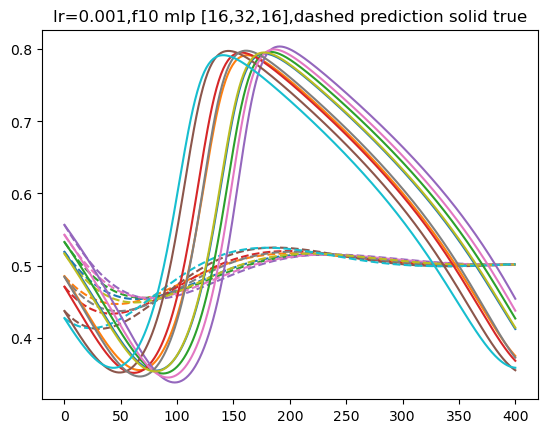

In [15]:
pred_traj = torch.stack(pred_list, dim=0)
true_traj = torch.stack(true_list, dim=0)
plt.plot(pred_traj[:500,0,:].detach(),'--',label='prediction')
plt.plot(true_traj[:500,0,:],label='true')
plt.title('lr=0.001,f10 mlp [16,32,16],dashed prediction solid true')
plt.show()

In [6]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch.nn as nn

class GCN(torch.nn.Module):
    def __init__(self, hidden_sizes):
        super(GCN, self).__init__()
        
        self.layers = nn.ModuleList()

        input_size = 2
        
        # Create GCN layers based on hidden_sizes
        for hidden_size in hidden_sizes:
            self.layers.append(GCNConv(input_size, hidden_size))
            input_size = hidden_size
            
        self.layers.append(GCNConv(input_size, 2))

    def forward(self, x, edge_index, edge_attr):
        for i in range(len(self.layers) - 1):
            x = self.layers[i](x, edge_index, edge_attr)
            x = F.relu(x)
            x = F.dropout(x, training=self.training)
            
        x = self.layers[-1](x, edge_index, edge_attr)
        return x


In [7]:
adj = torch.ones(n_nodes,n_nodes)
torch.diagonal(adj, 0).zero_()
edge_index = adj.nonzero().t().contiguous()
edge_attr = A[edge_index[0], edge_index[1]]

In [24]:
import os
import pandas as pd

# Ensure that the 'grid_search' directory exists
save_path = 'gcn_grid_search'
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Define your grid
node_hidden_layer_combinations = [[6,3],[6,12,6], [6,12,24,12,6]]
learning_rates = [0.001, 0.01, 0.1]

grid = [(n_sizes, lr) for n_sizes in node_hidden_layer_combinations for lr in learning_rates]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer_class = torch.optim.Adam
loss_fn = nn.MSELoss()
look_ahead = 10

max_epochs = 100000

train_generator = data_nocontrol(1, 400, **args)  
valid_generator = data_nocontrol(1, 400, **args)  # A separate generator for validation

# Start the grid search
results_2 = []
for node_sizes, learning_rate in grid:
    print(f"Training for Node Hidden Sizes: {node_sizes} and Learning Rate: {learning_rate}")

    # Create your models with the current hyperparameters

    model = GCN(node_sizes).to(device)

    optimizer = optimizer_class(model.parameters(), lr=learning_rate, weight_decay=5e-4)
    
    train_losses = []
    valid_losses = []
    epoch = 0
    loss_value = float('inf')
    
    # Your training loop remains largely unchanged
    while loss_value > 1e-6 and epoch < max_epochs:
        # Training step
        states = next(train_generator)
        states = states.to(device)
        if states.shape[0] == 1:
            states = states.squeeze(0)
        
        model.train()
        optimizer.zero_grad()
        loss = 0
        current_state = states[0, :]
        for k in range(look_ahead-1):
            prediction = model(current_state.T,edge_index,edge_attr).T
            loss = loss + loss_fn(prediction, states[k + 1, :])
            current_state = prediction
        
        loss.backward()
        optimizer.step()
        
        # Store and print the loss
        loss_value = loss.item()
        train_losses.append(loss_value)
        
        # Validation step
        with torch.no_grad():
            model.eval()  # Switch the model to evaluation mode
            states = next(valid_generator)
            states = states.to(device)
            if states.shape[0] == 1:
                states = states.squeeze(0)
            
            valid_loss = 0
            current_state = states[0, :]
            for k in range(look_ahead-1):
                prediction = model(current_state.T,edge_index,edge_attr).T
                valid_loss += loss_fn(prediction, states[k + 1, :])
                current_state = prediction
                
            valid_losses.append(valid_loss.item())

        epoch += 1
            
    best_train_loss = min(train_losses)
    avg_last_N_train_losses = sum(train_losses[-10000:]) / 10000
    best_valid_loss = min(valid_losses)
    avg_last_N_valid_losses = sum(valid_losses[-10000:]) / 10000
    results_2.append((node_sizes, learning_rate, best_train_loss, avg_last_N_train_losses, best_valid_loss, avg_last_N_valid_losses,train_losses,valid_losses))
    print(f"epoch {epoch},node sizes{node_sizes},learning rate{learning_rate},best train/val loss{best_train_loss}/{best_valid_loss},avg loss{avg_last_N_train_losses}/{avg_last_N_valid_losses}")
    
    # Save model, training losses, and validation losses if needed
    model_path = os.path.join(save_path, f"model_node_{'_'.join(map(str, node_sizes))}_lr_{learning_rate}.pth")
    train_losses_path = os.path.join(save_path, f"train_losses_node_{'_'.join(map(str, node_sizes))}_lr_{learning_rate}.txt")
    valid_losses_path = os.path.join(save_path, f"valid_losses_node_{'_'.join(map(str, node_sizes))}_lr_{learning_rate}.txt")
    
    torch.save(model.state_dict(), model_path)
    


    df = pd.DataFrame({
        "train_loss": train_losses,
        "valid_loss": valid_losses
    })
    file_name = os.path.join(save_path, f"losses_node_{'_'.join(map(str, node_sizes))}_lr_{learning_rate}.csv")
    df.to_csv(file_name, index=False)        

Training for Node Hidden Sizes: [6, 3] and Learning Rate: 0.001
epoch 100000,node sizes[6, 3],learning rate0.001,best train/val loss0.0016029223334044218/0.0015470408834517002,avg loss0.09123120554251364/0.09377066503704991
Training for Node Hidden Sizes: [6, 3] and Learning Rate: 0.01
epoch 100000,node sizes[6, 3],learning rate0.01,best train/val loss0.0005142368609085679/0.0012946437345817685,avg loss0.05039134369250387/0.10147833811286837
Training for Node Hidden Sizes: [6, 3] and Learning Rate: 0.1
epoch 100000,node sizes[6, 3],learning rate0.1,best train/val loss0.00042240245966240764/0.0014132732758298516,avg loss0.036667164146038704/0.12553447590961586
Training for Node Hidden Sizes: [6, 12, 6] and Learning Rate: 0.001
epoch 100000,node sizes[6, 12, 6],learning rate0.001,best train/val loss0.0013569362927228212/0.002028602873906493,avg loss0.09158734341948294/0.11593848760593682
Training for Node Hidden Sizes: [6, 12, 6] and Learning Rate: 0.01
epoch 100000,node sizes[6, 12, 6],

In [8]:
import os
import pandas as pd

# Ensure that the 'grid_search' directory exists
save_path = 'gcn_grid_search'
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Define your grid
node_hidden_layer_combinations = [[16,32,16], [16, 32, 64,32,16]]
learning_rates = [0.001, 0.01, 0.1]

grid = [(n_sizes, lr) for n_sizes in node_hidden_layer_combinations for lr in learning_rates]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer_class = torch.optim.Adam
loss_fn = nn.MSELoss()
look_ahead = 10

max_epochs = 100000

train_generator = data_nocontrol(1, 400, **args)  
valid_generator = data_nocontrol(1, 400, **args)  # A separate generator for validation

# Start the grid search
results_2 = []
for node_sizes, learning_rate in grid:
    print(f"Training for Node Hidden Sizes: {node_sizes} and Learning Rate: {learning_rate}")

    # Create your models with the current hyperparameters

    model = GCN(node_sizes).to(device)

    optimizer = optimizer_class(model.parameters(), lr=learning_rate, weight_decay=5e-4)
    
    train_losses = []
    valid_losses = []
    epoch = 0
    loss_value = float('inf')
    
    # Your training loop remains largely unchanged
    while loss_value > 1e-6 and epoch < max_epochs:
        # Training step
        states = next(train_generator)
        states = states.to(device)
        if states.shape[0] == 1:
            states = states.squeeze(0)
        
        model.train()
        optimizer.zero_grad()
        loss = 0
        current_state = states[0, :]
        for k in range(look_ahead-1):
            prediction = model(current_state.T,edge_index,edge_attr).T
            loss = loss + loss_fn(prediction, states[k + 1, :])
            current_state = prediction
        
        loss.backward()
        optimizer.step()
        
        # Store and print the loss
        loss_value = loss.item()
        train_losses.append(loss_value)
        
        # Validation step
        with torch.no_grad():
            model.eval()  # Switch the model to evaluation mode
            states = next(valid_generator)
            states = states.to(device)
            if states.shape[0] == 1:
                states = states.squeeze(0)
            
            valid_loss = 0
            current_state = states[0, :]
            for k in range(look_ahead-1):
                prediction = model(current_state.T,edge_index,edge_attr).T
                valid_loss += loss_fn(prediction, states[k + 1, :])
                current_state = prediction
                
            valid_losses.append(valid_loss.item())

        epoch += 1
            
    best_train_loss = min(train_losses)
    avg_last_N_train_losses = sum(train_losses[-10000:]) / 10000
    best_valid_loss = min(valid_losses)
    avg_last_N_valid_losses = sum(valid_losses[-10000:]) / 10000
    results_2.append((node_sizes, learning_rate, best_train_loss, avg_last_N_train_losses, best_valid_loss, avg_last_N_valid_losses,train_losses,valid_losses))
    print(f"epoch {epoch},node sizes{node_sizes},learning rate{learning_rate},best train/val loss{best_train_loss}/{best_valid_loss},avg loss{avg_last_N_train_losses}/{avg_last_N_valid_losses}")
    
    # Save model, training losses, and validation losses if needed
    model_path = os.path.join(save_path, f"model_node_{'_'.join(map(str, node_sizes))}_lr_{learning_rate}.pth")
    train_losses_path = os.path.join(save_path, f"train_losses_node_{'_'.join(map(str, node_sizes))}_lr_{learning_rate}.txt")
    valid_losses_path = os.path.join(save_path, f"valid_losses_node_{'_'.join(map(str, node_sizes))}_lr_{learning_rate}.txt")
    
    torch.save(model.state_dict(), model_path)
    


    df = pd.DataFrame({
        "train_loss": train_losses,
        "valid_loss": valid_losses
    })
    file_name = os.path.join(save_path, f"losses_node_{'_'.join(map(str, node_sizes))}_lr_{learning_rate}.csv")
    df.to_csv(file_name, index=False)        

Training for Node Hidden Sizes: [16, 32, 16] and Learning Rate: 0.001
epoch 100000,node sizes[16, 32, 16],learning rate0.001,best train/val loss0.0023342110216617584/0.0027022354770451784,avg loss0.06759230474920477/0.1025960839397274
Training for Node Hidden Sizes: [16, 32, 16] and Learning Rate: 0.01
epoch 100000,node sizes[16, 32, 16],learning rate0.01,best train/val loss0.0005117803229950368/0.001963614718988538,avg loss0.05084374081440037/0.1039985971593298
Training for Node Hidden Sizes: [16, 32, 16] and Learning Rate: 0.1
epoch 100000,node sizes[16, 32, 16],learning rate0.1,best train/val loss0.0011716402368620038/0.0028808384668082,avg loss2.519523585418182e+27/9.463631748009327e+21
Training for Node Hidden Sizes: [16, 32, 64, 32, 16] and Learning Rate: 0.001
epoch 100000,node sizes[16, 32, 64, 32, 16],learning rate0.001,best train/val loss0.0014853335451334715/0.002240184461697936,avg loss0.07302878887127154/0.11432304357262328
Training for Node Hidden Sizes: [16, 32, 64, 32, 

In [17]:
#best GCN is [16,32,16] with lr 0.01
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_node_sizes = [16, 32, 64, 32, 16]
model = GCN(best_node_sizes).to(device)
model.load_state_dict(torch.load('./gcn_grid_search/model_node_16_32_64_32_16_lr_0.01.pth'))

<All keys matched successfully>

In [19]:
model.eval()
sim_length=400
t = 0
state = pred_list[0]
pred_list2 = [state]

while t<sim_length:
    x = pred_list2[t]
    pred = model(x.T,edge_index,edge_attr).T
    pred_list2.append(pred)
    t = t+1

In [27]:
edge_attr.shape

torch.Size([90])

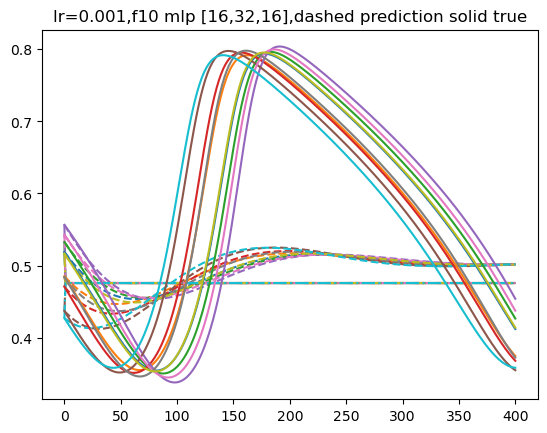

In [23]:
pred_traj2 = torch.stack(pred_list2, dim=0)
plt.plot(pred_traj[:500,0,:].detach(),'--',label='prediction')
plt.plot(pred_traj2[:500,0,:].detach(),'-.',label='prediction')
plt.plot(true_traj[:500,0,:],label='true')
plt.title('lr=0.001,f10 mlp [16,32,16],dashed prediction solid true')
plt.show()

In [ ]:
pred_traj2 = torch.stack(pred_list2, dim=0)
plt.plot(pred_traj[:500,0,:].detach(),'--',label='prediction')
plt.plot(pred_traj2[:500,0,:].detach(),'-.',label='prediction')
plt.plot(true_traj[:500,0,:],label='true')

plt.show()

In [10]:
a=next(train_generator)
a.dtype

torch.float32

In [12]:
edge_attr.dtype

torch.float32